You can perform PID on MI(r;(x,v)), and compare the result of different 'x'.
'x' can from experimental data or produce in this code for different Tau (Gramma) or cutoff frequency
'r' can be real responses of RGC or from NGD or from x+$\Delta$*v.
Using 20200408 Chou's data, unit2.

# Functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib.ticker import MaxNLocator
import math
from scipy import signal
from scipy.fftpack import fft
from scipy import ndimage
from scipy.io import loadmat
from scipy.stats import loglaplace,chi2

from labellines import labelLine, labelLines
import os
%matplotlib inline

In [2]:
import import_ipynb
os.chdir('C:\\Users\\hydro_leo\\Documents\\GitHub\\python-code\\Modules')
from time_shifted_PID import Histo3D2Dict
from time_shifted_PID import PIfunc
from time_shifted_PID import EqualState
from Spike_Generation import Spike_Time_Generater
from Spike_Generation import NL
from StimulusnResponse import expSnR

importing Jupyter notebook from time_shifted_PID.ipynb
importing Jupyter notebook from J_broja_PID.ipynb
importing Jupyter notebook from Spike_Generation.ipynb
importing Jupyter notebook from StimulusnResponse.ipynb


# Main

Loading Exp.mat for position series

In [4]:
loadfiles = np.load('4PID_paper\\lambda vs. PI\\PeakHeightnTime vs Fc.npz', allow_pickle=True)
for k in loadfiles.files:
    vars()[k] = loadfiles[k][()]

loadfiles = np.load('4PID_paper\\beta vs. PI\\PeakHeightnTime vs Fc.npz', allow_pickle=True)
for k in loadfiles.files:
    vars()['b_'+k] = loadfiles[k][()]

Fc_list = [2,4,7,10]
filenames = ['D:\\GoogleDrive\\retina\\Chou\'s data\\20200408\\20200408_OU_cutoff='+str(Fc)+'_sort_unit2' for Fc in Fc_list]
dt = 0.01
x_list, T_list, rstate_list = expSnR(filenames, dt, 'LED', [53])
for i in range(len(x_list)):
    rstate_list[i] = rstate_list[i][53-1,:]

for i in range(len(x_list)):
    x_cor = np.correlate(x_list[i], x_list[i], "same")
    x_cor = x_cor[:int((len(x_cor)+1)/2)+1]
    Taxis = np.flip(T_list[i][:len(x_cor)]-dt/2)
    t_cor_list.append( round(np.interp(0.5*max(x_cor),  x_cor, Taxis), 3))

FileNotFoundError: [Errno 2] No such file or directory: '4PID_paper\\lambda vs. PI\\PeakHeightnTime vs Fc.npz'

In [11]:
t_cor_list

[0.524, 0.422, 0.395, 0.385]

In [17]:
pcells = [20,33,40,42,53]
pcell_pos = [[3,3], [5,6], [6,7], [6,5], [7,2]]
Uvox_ratio_list_cells = []
Lambda_list_cells = []
maxxs = np.zeros((len(pcells), len(x_list)))
maxvs = np.zeros((len(pcells), len(x_list)))
p = 0
v_list = []
for i in range(len(x_list)):
    v = np.append( 0,np.diff(x_list[i]) )
    v_list.append(v.copy())
for pcell in pcells:
    Fc_list = [2,4,7,10]
    x_list, T_list, dt, rstate_list = Get_StimulusnResponse('Exp', 'Fc', Fc_list,_, pcell)
    # x_list, T_list, dt, rstate_list = Get_StimulusnResponse('Exp', 'Gramma', [2.5,4.3,4.5,7.5,20],_, 21)
    # x_list, T_list, dt, _ = Get_StimulusnResponse('Sim', 'Fc', [0.5,1,2,4,8], 1)
    # x_list, T_list, dt, _ = Get_StimulusnResponse('Sim', 'Tau', [1.8,1.4,1,0.6,0.22], 1)
    #assign states
    ystate_list = []
    xstate_list = []
    vstate_list = []

    for i in range(len(x_list)):
        xstate, _= EqualState(x_list[i], 6)
        vstate, _= EqualState(v_list[i], 6)
        xstate_list.append(xstate)
        vstate_list.append(vstate)

    window = [-1,1] # second
    Information_list = [0]*len(x_list)
    Uvox_ratio_list = []
    Lambda_list = []
    for i in range(len(x_list)):
        timeshift, Information_list[i] = PIfunc(rstate_list[i], xstate_list[i], vstate_list[i], dt, window)
        Uvox_ratio_table = ndimage.gaussian_filter1d(Uv_peakH_list[i]/Ux_peakH_list[i], sigma=1, mode='reflect')
        Uvox_ratio = max(Information_list[i][('Beer','UIv')])/max(Information_list[i][('Beer','UIx')])
        maxxs[p,i] = max(Information_list[i][('Beer','UIv')])
        maxvs[p,i] = max(Information_list[i][('Beer','UIx')])
        
        Uvox_ratio_list.append(Uvox_ratio)
        Lambda = np.interp(Uvox_ratio, Uvox_ratio_table, Lambdas)
        Lambda_list.append(Lambda)
    p+=1
    Lambda_list_cells.append(Lambda_list)
    Uvox_ratio_list_cells.append(Uvox_ratio_list.copy())

C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: divide by zero encountered i

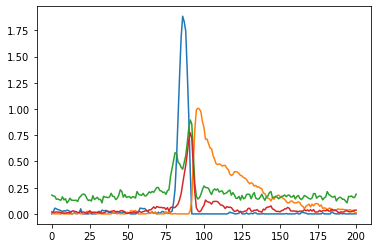

In [18]:
plt.plot(Information_list[i][('Beer','UIv')])
plt.plot(Information_list[i][('Beer','UIx')])
plt.plot(Information_list[i][('Beer','Syn')])
plt.plot(Information_list[i][('Beer','Red')])

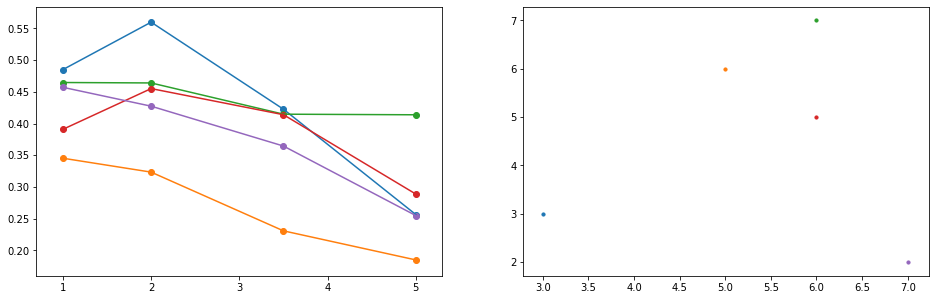

In [19]:
fig, (ax1, ax2) = plt.subplots(1,2)
for p in range(len(pcells)):
    ax1.plot(np.array(Fc_list)/2, np.array(Lambda_list_cells[p]), zorder=2 )
    ax1.scatter(np.array(Fc_list)/2, np.array(Lambda_list_cells[p]), zorder=2 )
    ax2.scatter(pcell_pos[p][0], pcell_pos[p][1], s =[10])
a = 4
fig.set_size_inches(a*4, a*(np.sqrt(5)-1))

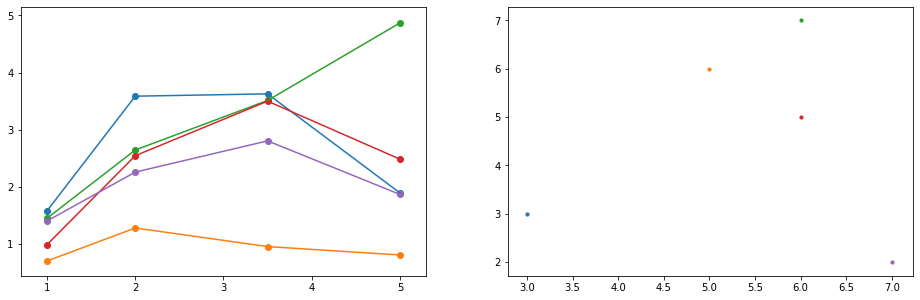

In [20]:
fig, (ax1, ax2) = plt.subplots(1,2)
for p in range(len(pcells)):
    ax1.plot(np.array(Fc_list)/2, np.array(Uvox_ratio_list_cells[p]), zorder=2 )
    ax1.scatter(np.array(Fc_list)/2, np.array(Uvox_ratio_list_cells[p]), zorder=2 )
    ax2.scatter(pcell_pos[p][0], pcell_pos[p][1], s =[10])
a = 4
fig.set_size_inches(a*4, a*(np.sqrt(5)-1))

# for paper

In [21]:
# import pandas as pd
# data_df = pd.DataFrame(pcell_pos)
# name  = 'lambdavsFc_Expt2'
# writer = pd.ExcelWriter('D:\\GoogleDrive\\retina\\PID_paper\\For Origin Plot\\'+name+'.xlsx')
# # create and writer pd.DataFrame to excel
# # data_df.to_excel(writer,'pos',float_format='%.5f') # float_format 控制精度


# data_df = pd.DataFrame(np.array(Lambda_list_cells).T)
# data_df.to_excel(writer,'lambdavFc',float_format='%.5f') # float_format 控制精度
# writer.save()